In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize
from omegaconf import OmegaConf

from utils.metric import score

In [3]:
def hide_submission(sub_df):
    hide_sub_df = sub_df.clone().with_columns(
        [pl.lit(0.0).alias(f"ptend_q0002_{i}") for i in range(12, 22)]
    )
    return hide_sub_df

In [4]:
base_sub_path = "gs://kaggle-leap/kami/20240610_ensemble_nelder_mead2_lb078544.parquet"
base_sub_df = pl.read_parquet(base_sub_path)
base_sub_df.head()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_0""",0.000003,-0.000065,-0.000085,-0.000086,-0.000096,-0.0001,-0.000082,-0.000064,-0.000049,-0.000041,-0.000028,-0.000018,-0.000009,-0.000004,-4.1657e-7,0.000001,0.000006,0.000004,0.000003,-0.000009,0.000009,-0.000003,-0.000012,-0.000016,-0.000015,-0.000013,-0.000016,-0.000018,-0.000023,-0.000031,-0.000037,-0.000032,-0.000023,-0.000018,-0.000017,-0.000015,…,9.3603e-7,0.000002,-4.3578e-7,-0.000002,-0.000001,-6.4969e-7,-8.2227e-7,-0.000003,-7.8813e-7,-5.8951e-7,1.9074e-7,-0.000003,0.000006,0.000001,0.000002,-0.000005,-0.000006,-0.000026,-0.000048,-0.000048,-0.000018,0.000038,0.000043,0.000042,0.000022,0.000012,0.000009,0.000008,4.1996e-7,-0.136167,402.35946,4.6684e-11,4.1327e-10,-0.033577,-0.049489,0.09329,0.212398
"""test_10""",-0.000015,-0.00005,-0.000034,-0.000052,-0.00009,-0.000133,-0.000142,-0.000097,-0.000046,-0.000026,-0.000018,-0.000014,-0.000011,-0.000009,-0.000007,-0.000005,-0.000004,-0.000004,-0.000002,-0.000004,-0.000004,-0.000008,-0.000008,-0.000009,-0.000008,-0.000011,-0.000013,-0.000017,-0.00002,-0.000018,-0.00002,-0.000019,-0.000015,-0.000007,-0.000002,0.000003,…,-4.8681e-7,-3.7356e-7,2.0193e-7,4.7321e-7,3.4525e-7,2.1168e-7,1.7050e-7,6.5687e-8,2.0065e-8,2.7567e-9,1.3472e-7,-8.9901e-7,4.5322e-7,-3.2823e-7,0.000001,-4.6198e-9,-5.7225e-7,-0.000002,-0.000002,-0.000002,-0.000002,-0.000001,-1.4282e-7,9.2288e-7,0.000002,0.000001,8.3161e-7,-0.000002,0.000004,-0.027761,345.154827,2.5575e-11,-5.9339e-10,-0.316943,-0.456919,0.0302,0.172592
"""test_100""",-0.000007,-0.00008,-0.000033,-0.000028,-0.000073,-0.000096,-0.000079,-0.000053,-0.00003,-0.000021,-0.000017,-0.000014,-0.000012,-0.00001,-0.000007,-0.000005,-0.000004,-0.000005,0.000004,-0.000009,-0.000004,-0.000007,-0.000006,-0.000006,-0.000004,-0.000003,-0.000006,-0.000006,-0.000007,-0.000011,-0.000015,-0.000019,-0.000022,-0.000022,-0.000024,-0.000024,…,-0.000002,-0.000002,-7.8204e-7,2.2820e-7,8.2554e-7,0.000001,8.8598e-7,8.5306e-7,6.2661e-7,3.6903e-7,1.7289e-8,-4.6920e-7,-1.9907e-7,0.000002,3.3318e-7,-0.000001,-7.2683e-7,-0.000004,-0.00001,-0.00002,-0.000023,0.000009,0.00001,0.000014,0.00001,0.000004,0.000004,0.000004,0.000012,2.065205,331.870707,3.9388e-12,6.2842e-10,0.947471,0.65194,0.288081,0.205645
"""test_1000""",0.000026,0.000007,0.000033,0.000026,-0.000013,-0.000057,-0.000047,-0.000021,-0.000008,-0.000003,-0.000001,-6.6297e-7,-3.7065e-7,0.000002,0.000003,0.000005,0.000006,0.000004,1.3132e-7,7.6130e-7,-4.3587e-7,-0.000002,-0.00001,-0.000019,-0.000017,-0.000014,-0.000014,-0.000017,-0.000021,-0.000023,-0.000021,-0.00002,-0.000018,-0.000017,-0.000016,-0.000017,…,2.6728e-8,-4.6045e-8,6.6996e-7,-0.000001,8.5986e-8,0.000001,-0.000001,1.5021e-7,-9.4691e-7,3.3675e-7,-0.000005,0.000007,0.000003,0.000005,0.000007,0.000007,0.000007,0.00001,0.00001,0.000008,0.000006,0.000004,9.9584e-7,-0.000006,-0.000012,-0.000022,-0.000039,-0.000046,0.000025,2.73912,361.004821,-3.

## timestamp使った予測値で置き換える

In [5]:
time_sub_path = "gs://kaggle-leap/kami/experiments/610_sim6/mid/submission.parquet"
time_sub_df = pl.read_parquet(time_sub_path)
time_sub_df.tail()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_99994""",0.000049,-0.000014,0.000017,0.000092,0.000122,0.000152,0.000135,0.000099,0.000062,0.000045,0.000036,0.00003,0.000024,0.000017,0.000011,0.00001,0.000009,0.000004,0.000002,0.000006,0.000006,9.6646e-9,-0.000009,0.000003,-0.000004,-0.000001,-0.000007,-0.000024,-0.000027,-0.000005,-0.00002,-0.000022,-0.000004,-0.000007,-0.000005,-0.000008,…,0.000016,-0.000008,-0.000011,-0.000018,-0.000007,-0.000002,-0.000006,-0.000023,-0.000035,-0.000026,-0.000015,-0.000013,-0.000019,-0.000016,-0.000009,-9.7080e-7,0.000009,0.000011,0.000018,0.000049,0.000053,0.000048,0.000041,0.000029,0.000015,0.000006,0.000001,0.000001,0.000006,399.04611,401.382947,-1.5271e-10,6.6942e-8,171.562718,181.812864,58.599328,21.616242
"""test_99995""",0.000008,-0.000058,-0.000148,-0.000076,-0.000063,-0.000054,-0.000044,-0.000037,-0.000029,-0.000021,-0.000015,-0.000011,-0.000009,-0.000009,-0.000008,-0.000007,-0.000007,-0.000007,-0.000006,-0.000006,-0.000005,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000005,-0.000005,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,-0.000007,…,1.7207e-10,-1.8932e-8,-1.2410e-8,2.0099e-9,7.9380e-10,-1.2611e-8,-2.5287e-8,-2.4455e-8,-7.7381e-9,-2.4830e-8,2.4685e-10,-1.3635e-8,4.2712e-9,-3.3214e-9,-2.4595e-10,8.2156e-9,2.6690e-8,-7.8904e-10,5.2038e-8,3.0195e-9,1.8045e-8,5.9917e-8,8.5916e-10,-9.2541e-9,-7.7758e-8,0.000001,-7.8526e-7,0.000003,-0.000004,4.128117,129.454714,2.4516e-9,2.5919e-9,-2.794531,0.167184,0.947156,0.278601
"""test_99996""",0.000031,0.000007,0.000014,0.000023,0.000038,0.000057,0.000052,0.000035,0.000022,0.000014,0.000009,0.000006,0.000005,0.000005,0.000005,0.000004,0.000003,0.000001,0.000002,-5.1099e-9,-1.8696e-7,-8.5789e-7,-0.000001,-0.000001,-0.000002,-0.000001,-0.000001,-9.1397e-7,-7.0128e-7,-6.8083e-7,-0.000001,-0.000002,-0.000003,-0.000002,-0.000003,-0.000003,…,-1.1775e-9,1.2595e-9,1.7976e-8,1.2556e-8,3.5801e-9,-6.9413e-9,-2.1745e-8,-2.5806e-8,-4.2072e-8,-1.6486e-8,6.4778e-9,1.4215e-8,1.4364e-8,2.7725e-8,3.1253e-8,8.5301e-8,5.1695e-8,2.6145e-8,3.5554e-8,2.4522e-8,3.3049e-9,-4.3264e-8,-2.6685e-8,-8.5703e-8,-5.7899e-8,-2.6684e-8,1.0132e-7,-1.7862e-7,-1.0988e-7,54.404942,179.010257,6.1634e-9,2.4665e-9,116.811957,171.915093,65.05633,19.937927
"""test_99997""",-0.00002,-0.000017,-0.000037,-0.000055,-0.000081,-0.000108,-0.000098,-0.000068,-0.000044,-0.000037,-0.000028,-0.000021,-0.000014,-0.000009,-0.000003,8.4431e-7,0.000002,0.000006,-0.000001,0.000001,-0.000006,-0.00001,-0.000004,-0.000011,-0.000018,-0.00001,-0.000034,-0.000037,-0.00002,-0.000022,-0.000031,-0.000016,-0.000018,-0.000039,-0.000028,-0.000033,…,2.7996e-7,-0.000003,-0.000003,-0.000003,-0.000001,-0.000001,0.000002,0.000008,-0.000027,-0.000035,-0.000014,-0.000002,0.000011,0.000027,0.000036,0.000036,0.000033,0.000027,0.000021,0.000013,0.000006,-0.000003,-0.00001,-0.000015,-0.000021,-0.000024,-0.000028,-0.000032,-0.

In [39]:
class_exps = ["702_multi_class11/mid", "702_multi_class11/all", "701_multi_class/small"]
# class_exp = "701_multi_class/small"
# class_exp = "700_binary_classify/small"

In [41]:
# 閾値ごとの値をチェック

from sklearn.metrics import precision_score, recall_score

valid_preds_list = []
for class_exp in class_exps:
    val2_predict_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/val2_predict.parquet"
    )
    val2_label_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/val2_label.parquet"
    )
    valid_preds = val2_predict_df.select(["0"]).to_numpy()  # classの番号
    valid_preds_list.append(valid_preds)
    valid_y_class = val2_label_df.select(["0"]).to_numpy() == 0
valid_preds = np.mean(valid_preds_list, axis=0)

thresholds = [0.5, 0.999, 0.9999, 0.99995, 0.99997, 0.99998, 0.99999]
for threshold in thresholds:
    y_pred = (valid_preds > threshold).astype(np.int64)
    # リコールと精度を計算
    num_cand = np.sum(y_pred)
    precision = precision_score(valid_y_class, y_pred)
    recall = recall_score(valid_y_class, y_pred)
    print(
        f"Threshold: {threshold:.5f}, Num:{num_cand}, Precision: {precision:.5f}, Recall: {recall:.5f}"
    )

Threshold: 0.50000, Num:163390, Precision: 0.99663, Recall: 0.99999
Threshold: 0.99900, Num:160852, Precision: 0.99998, Recall: 0.98776
Threshold: 0.99990, Num:154407, Precision: 0.99999, Recall: 0.94820
Threshold: 0.99995, Num:150114, Precision: 0.99999, Recall: 0.92184
Threshold: 0.99997, Num:145841, Precision: 1.00000, Recall: 0.89560
Threshold: 0.99998, Num:141607, Precision: 1.00000, Recall: 0.86960
Threshold: 0.99999, Num:132300, Precision: 1.00000, Recall: 0.81245


In [15]:
class_preds_list = []
for class_exp in class_exps:
    class_pred_df = pl.read_parquet(
        f"gs://kaggle-leap/kami/experiments/{class_exp}/test_predict.parquet"
    )
    class_preds = class_pred_df.get_column("0").to_numpy().reshape(-1)
    class_preds_list.append(class_preds)
class_preds = np.mean(class_preds_list, axis=0)

class_pred_df.tail()

index,0,1,2,3,4
i64,f32,f32,f32,f32,f32
624995,1.0,2.0277e-7,1.1019e-7,2.1507e-8,1.0022e-10
624996,0.000012,0.987593,0.012306,0.000088,1.8166e-7
624997,0.99999,0.000005,3.0728e-7,0.000004,1.1756e-9
624998,2.9659e-7,0.999991,0.000007,9.7062e-7,8.0808e-9
624999,4.3638e-7,0.000002,0.000559,0.006239,0.9932


In [16]:
# takoi-san check
print(base_sub_df["sample_id"].to_numpy()[class_preds > 0.999])
df = pl.read_parquet("output/exp152_143.parquet")
df.sort("sample_id")

['test_100008' 'test_100009' 'test_100016' ... 'test_99976' 'test_99994'
 'test_99996']


nears,dist,old_time,new_place,sample_id,time_6_18_66_78,old_place
i64,f32,i64,i64,str,i64,i64
258761,0.005093,20190,329,"""test_100008""",0,329
456820,0.01054,35670,244,"""test_100016""",0,244
235737,0.011838,18390,345,"""test_100023""",0,345
234122,0.00494,18270,266,"""test_100027""",0,266
69637,0.028217,5430,133,"""test_100028""",0,133
…,…,…,…,…,…,…
412236,0.018188,32190,204,"""test_99956""",0,204
419900,0.01401,32790,188,"""test_99969""",0,188
392107,0.007062,30630,43,"""test_99976""",0,43


In [23]:
# 閾値以上の行について、カラムごとにR2を計算して一定値以上であれば置き換えを行う
from sklearn.metrics import r2_score

threshold = 0.99999
replace_index = class_preds > threshold
print(f"replace num:{replace_index.sum()} rate:{replace_index.sum()/len(class_preds)}")

replace_sub_df = base_sub_df.clone()
r2_score_vals = []

for col in base_sub_df.columns[1:]:
    time_pred = time_sub_df[col].to_numpy()
    base_pred = base_sub_df[col].to_numpy()
    r2_score_val = r2_score(
        base_pred[replace_index],
        time_pred[replace_index],
    )
    if r2_score_val > 0.5:
        replace_pred = base_sub_df[col].to_numpy().copy()
        replace_pred[replace_index] = time_pred[replace_index]
        replace_sub_df = replace_sub_df.with_columns(
            pl.Series(name=col, values=replace_pred)
        )
        r2_score_vals.append(r2_score_val)
    else:
        print(col, r2_score_val)

replace num:90195 rate:0.144312


In [15]:
replace_sub_df.write_parquet("output/2024-07-08_hack_sub_v2.parquet")
replace_sub_df.head()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_0""",0.000003,-0.000065,-0.000085,-0.000086,-0.000096,-0.0001,-0.000082,-0.000064,-0.000049,-0.000041,-0.000028,-0.000018,-0.000009,-0.000004,-4.1657e-7,0.000001,0.000006,0.000004,0.000003,-0.000009,0.000009,-0.000003,-0.000012,-0.000016,-0.000015,-0.000013,-0.000016,-0.000018,-0.000023,-0.000031,-0.000037,-0.000032,-0.000023,-0.000018,-0.000017,-0.000015,…,9.3603e-7,0.000002,-4.3578e-7,-0.000002,-0.000001,-6.4969e-7,-8.2227e-7,-0.000003,-7.8813e-7,-5.8951e-7,1.9074e-7,-0.000003,0.000006,0.000001,0.000002,-0.000005,-0.000006,-0.000026,-0.000048,-0.000048,-0.000018,0.000038,0.000043,0.000042,0.000022,0.000012,0.000009,0.000008,4.1996e-7,-0.136167,402.35946,4.6684e-11,4.1327e-10,-0.033577,-0.049489,0.09329,0.212398
"""test_10""",-0.000015,-0.00005,-0.000034,-0.000052,-0.00009,-0.000133,-0.000142,-0.000097,-0.000046,-0.000026,-0.000018,-0.000014,-0.000011,-0.000009,-0.000007,-0.000005,-0.000004,-0.000004,-0.000002,-0.000004,-0.000004,-0.000008,-0.000008,-0.000009,-0.000008,-0.000011,-0.000013,-0.000017,-0.00002,-0.000018,-0.00002,-0.000019,-0.000015,-0.000007,-0.000002,0.000003,…,-4.8681e-7,-3.7356e-7,2.0193e-7,4.7321e-7,3.4525e-7,2.1168e-7,1.7050e-7,6.5687e-8,2.0065e-8,2.7567e-9,1.3472e-7,-8.9901e-7,4.5322e-7,-3.2823e-7,0.000001,-4.6198e-9,-5.7225e-7,-0.000002,-0.000002,-0.000002,-0.000002,-0.000001,-1.4282e-7,9.2288e-7,0.000002,0.000001,8.3161e-7,-0.000002,0.000004,-0.027761,345.154827,2.5575e-11,-5.9339e-10,-0.316943,-0.456919,0.0302,0.172592
"""test_100""",-0.000007,-0.00008,-0.000033,-0.000028,-0.000073,-0.000096,-0.000079,-0.000053,-0.00003,-0.000021,-0.000017,-0.000014,-0.000012,-0.00001,-0.000007,-0.000005,-0.000004,-0.000005,0.000004,-0.000009,-0.000004,-0.000007,-0.000006,-0.000006,-0.000004,-0.000003,-0.000006,-0.000006,-0.000007,-0.000011,-0.000015,-0.000019,-0.000022,-0.000022,-0.000024,-0.000024,…,-0.000002,-0.000002,-7.8204e-7,2.2820e-7,8.2554e-7,0.000001,8.8598e-7,8.5306e-7,6.2661e-7,3.6903e-7,1.7289e-8,-4.6920e-7,-1.9907e-7,0.000002,3.3318e-7,-0.000001,-7.2683e-7,-0.000004,-0.00001,-0.00002,-0.000023,0.000009,0.00001,0.000014,0.00001,0.000004,0.000004,0.000004,0.000012,2.065205,331.870707,3.9388e-12,6.2842e-10,0.947471,0.65194,0.288081,0.205645
"""test_1000""",0.000026,0.000007,0.000033,0.000026,-0.000013,-0.000057,-0.000047,-0.000021,-0.000008,-0.000003,-0.000001,-6.6297e-7,-3.7065e-7,0.000002,0.000003,0.000005,0.000006,0.000004,1.3132e-7,7.6130e-7,-4.3587e-7,-0.000002,-0.00001,-0.000019,-0.000017,-0.000014,-0.000014,-0.000017,-0.000021,-0.000023,-0.000021,-0.00002,-0.000018,-0.000017,-0.000016,-0.000017,…,2.6728e-8,-4.6045e-8,6.6996e-7,-0.000001,8.5986e-8,0.000001,-0.000001,1.5021e-7,-9.4691e-7,3.3675e-7,-0.000005,0.000007,0.000003,0.000005,0.000007,0.000007,0.000007,0.00001,0.00001,0.000008,0.000006,0.000004,9.9584e-7,-0.000006,-0.000012,-0.000022,-0.000039,-0.000046,0.000025,2.73912,361.004821,-3.

In [24]:
# 符号が違うやつがどれくらいあるか
((base_sub_df[:, 1:].to_numpy() >= 0) ^ (replace_sub_df[:, 1:].to_numpy() >= 0)).sum()

3567454

In [36]:
(
    (base_sub_df[:, 1:].to_numpy()[replace_index] >= 0)
    ^ (replace_sub_df[:, 1:].to_numpy()[replace_index] >= 0)
).sum()

3567454

In [37]:
base_sub_df[:, 1:].to_numpy()[replace_index].shape

(90195, 368)

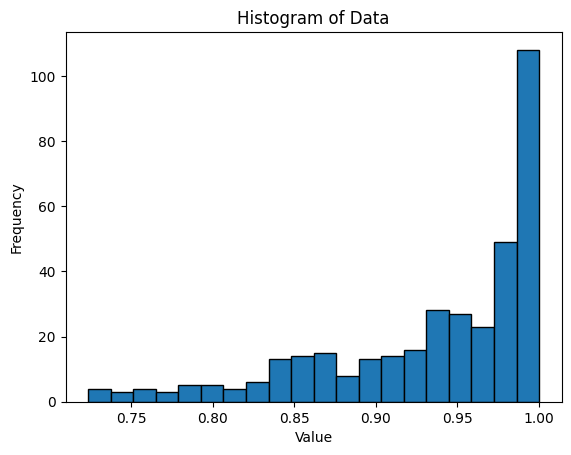

In [13]:
import matplotlib.pyplot as plt

# ヒストグラムをプロットするためのリストデータ

# ヒストグラムの描画
plt.hist(r2_score_vals, bins=20, edgecolor="black")

# グラフのタイトルとラベルを設定
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

# グラフを表示
plt.show()